In [16]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matscipy.dislocation as sd
from ase.io import read, lammpsdata
from lammps_implicit_der.tools import plot_tools

plotparams = plot_tools.plotparams.copy()
plotparams['font.size'] = 14
plotparams['figure.subplot.wspace'] = 0.2
plotparams['axes.labelsize'] = 18
plt.rcParams.update(plotparams)

# Structure Analysis

## Elastic constants

In [17]:
qm_alat = 3.18556

qm_C11 = 522  # pm 15 GPa
qm_C12 = 193  # pm 5 GPa
qm_C44 = 137  # pm 5 GPa


elastic_param = [qm_alat, qm_C11, qm_C12, qm_C44]

## Load the easy-core and hard-core structures

In [18]:
bulk_data = bulk = lammpsdata.read_lammps_data('bulk.lammps-data', atom_style='atomic', read_image_flags=False, sort_by_id=True)
easy_core_data = lammpsdata.read_lammps_data('easy_core.lammps-data', atom_style='atomic', read_image_flags=False, sort_by_id=True)
hard_core_data = lammpsdata.read_lammps_data('hard_core.lammps-data', atom_style='atomic', read_image_flags=False, sort_by_id=True)

In [19]:
# Subtract zmin from z coordinates (does not affect the structure, only for coloring)
for system in [bulk_data, easy_core_data, hard_core_data]:
    system.positions[:, 2] -= system.positions[:, 2].min()

## Compute the core positions with `matscipy`

In [20]:
easy_core_pos = sd.fit_core_position(easy_core_data, bulk_data, elastic_param, origin=(62,62))
hard_core_pos = sd.fit_core_position(hard_core_data, bulk_data, elastic_param, origin=(62,62))

print(f'Easy core position (A): {easy_core_pos}')
print(f'Hard core position (A): {hard_core_pos}')

Easy core position (A): [61.12245458 60.81561692]
Hard core position (A): [62.41807288 61.54776019]


## Plot the easy and hard cores

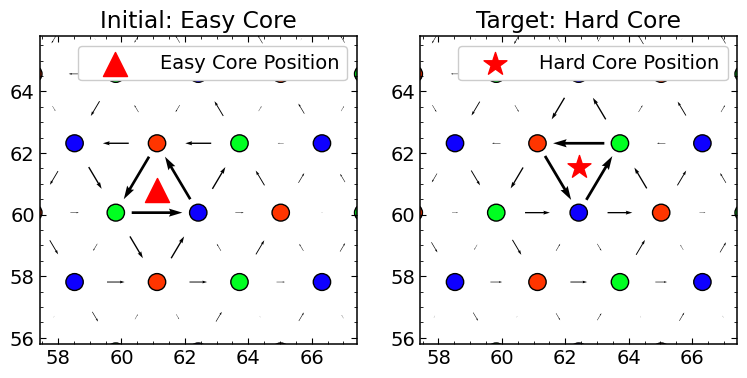

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sd.plot_vitek(easy_core_data, bulk_data, xyscale=5, plot_axes=axes[0])
axes[0].scatter(easy_core_pos[0], easy_core_pos[1],
                color='r', s=300, marker='^', label='Easy Core Position')

sd.plot_vitek(hard_core_data, bulk_data, xyscale=5, plot_axes=axes[1])
axes[1].scatter(hard_core_pos[0], hard_core_pos[1],
                color='r', s=300, marker='*', label='Hard Core Position')

axes[0].set_title('Initial: Easy Core')
axes[1].set_title('Target: Hard Core')
axes[0].legend(loc='upper right', framealpha=1)
axes[1].legend(loc='upper right', framealpha=1)

plt.show()

# Inverse Design

## Load minimization dict

In [22]:
# Path to the minimization output
# if obtained from the run
minim_folder = './minim_output/'

# The reference folder (to check the results)
#minim_folder = './REF_minim_output/'

pickle_path = os.path.join(minim_folder, 'minim_dict.pkl')

with open(pickle_path, 'rb') as f:
    minim_dict = pickle.load(f)

## Minimization stats

In [23]:
# Number of iterations for the loss minimization
numiter = minim_dict['numiter']
# Array of errors (loss function values)
error_array = minim_dict['error_array']
# Array of steps (import when adaptive_step=True)
step_array = minim_dict['step_array']

## Plot the stats

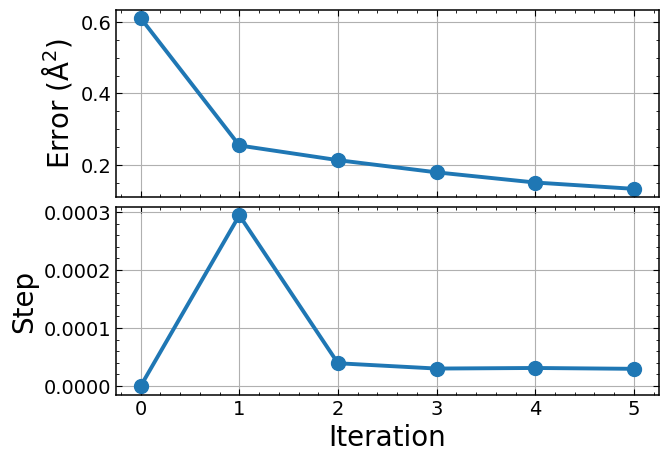

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
plt.subplots_adjust(hspace=0.05)

for ax in axes:
    ax.grid()

axes[1].plot(np.arange(numiter), step_array, 'o-')
axes[1].set_ylabel('Step', fontsize=20)

axes[0].plot(np.arange(numiter), error_array, 'o-')
axes[0].set_ylabel(r'Error ($\mathrm{\AA}^2$)', fontsize=20)

axes[1].set_xlabel('Iteration', fontsize=20)

plt.show()

## Load the minimized structure

In [25]:
minimize_data = lammpsdata.read_lammps_data(
                    f'{minim_folder}/data_step_{minim_dict["numiter"]-1:04d}.lammps-data',
                    atom_style='atomic', read_image_flags=False, sort_by_id=True)
minimize_data.positions[:, 2] -= minimize_data.positions[:, 2].min()

## Compute the dislocation core position of the minimized structure

In [26]:
minimize_core_pos = sd.fit_core_position(minimize_data, bulk_data, elastic_param, origin=(62,62))
print(f'Minimized core position (A): {minimize_core_pos}')

Minimized core position (A): [62.71623341 61.652951  ]


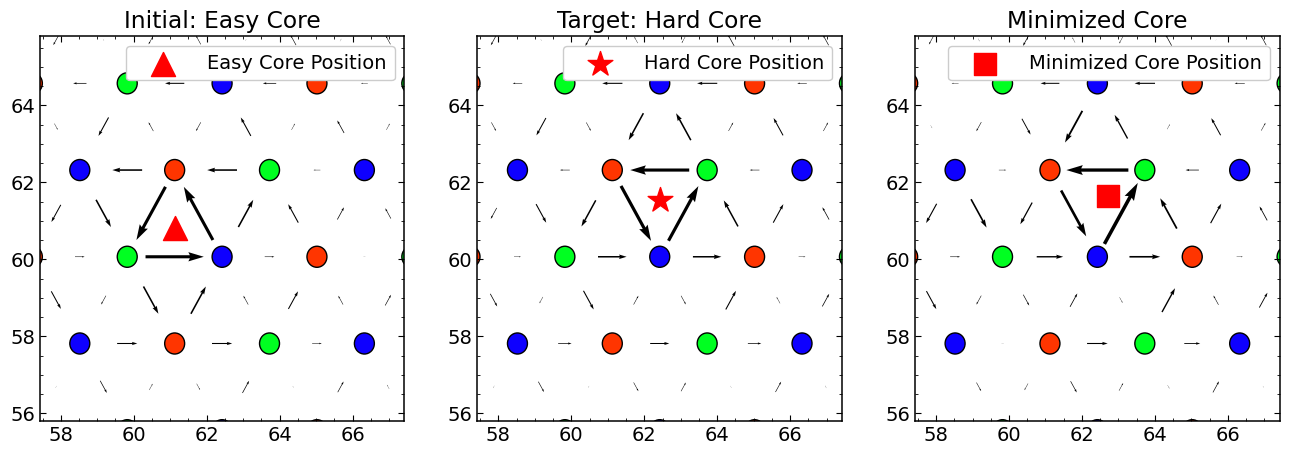

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sd.plot_vitek(easy_core_data, bulk_data, xyscale=5, plot_axes=axes[0])
axes[0].scatter(easy_core_pos[0], easy_core_pos[1],
                color='r', s=300, marker='^', label='Easy Core Position')

sd.plot_vitek(hard_core_data, bulk_data, xyscale=5, plot_axes=axes[1])
axes[1].scatter(hard_core_pos[0], hard_core_pos[1],
                color='r', s=350, marker='*', label='Hard Core Position')

sd.plot_vitek(minimize_data, bulk_data, xyscale=5, plot_axes=axes[2])
axes[2].scatter(minimize_core_pos[0], minimize_core_pos[1],
                color='r', s=250, marker='s', label='Minimized Core Position')

axes[0].set_title('Initial: Easy Core')
axes[1].set_title('Target: Hard Core')
axes[2].set_title('Minimized Core')
axes[0].legend(loc='upper right', framealpha=1)
axes[1].legend(loc='upper right', framealpha=1)
axes[2].legend(loc='upper right', framealpha=1)

plt.show()

## Compute the core positions for each loss minimization step

In [28]:
dislo_image_list = []
for iter in tqdm(range(minim_dict['numiter']), desc=f'Reading minimzation images'):
    dislo_minim_path = os.path.join(minim_folder, f'data_step_{iter:04d}.lammps-data')
    dislo_minim = lammpsdata.read_lammps_data(dislo_minim_path, atom_style='atomic', read_image_flags=False, sort_by_id=True)
    dislo_image_list.append(dislo_minim)

print('Computing core positions...')
core_pos_array = sd.fit_core_position_images(dislo_image_list, bulk, elastic_param, origin=(62, 62))

Reading minimzation images: 100%|██████████| 6/6 [00:00<00:00, 37.86it/s]


Computing core positions...


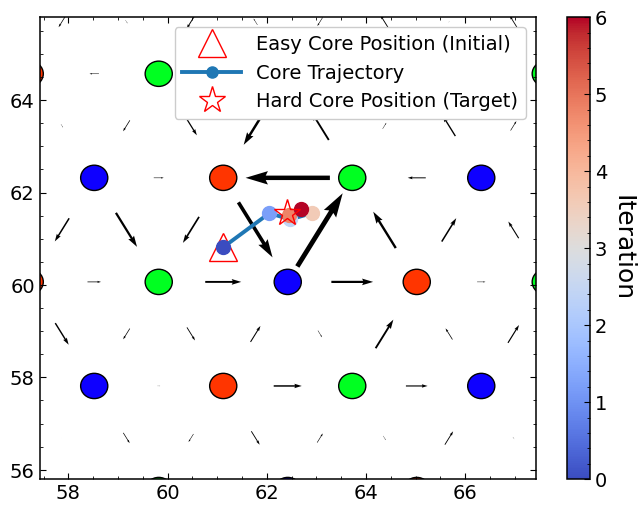

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Vitek plot from the final minimized image
sd.plot_vitek(minimize_data, bulk_data, xyscale=5, plot_axes=ax)

# Initial easy core position
ax.plot(easy_core_pos[0], easy_core_pos[1],
        color='r', ms=20, marker='^', fillstyle='none', ls='none',
        label='Easy Core Position (Initial)')

# Plot the "core trajectory" with color gradient from blue to red
ax.plot(core_pos_array[:, 0], core_pos_array[:, 1],
        marker='o', ms=8, label='Core Trajectory')

cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, minim_dict['numiter']))
for iter in range(minim_dict['numiter']):
    ax.plot(core_pos_array[iter, 0], core_pos_array[iter, 1],
            marker='o', color=colors[iter])

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=minim_dict['numiter']))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Iteration', rotation=270, labelpad=20)


# Plot the target hard core position
ax.plot(hard_core_pos[0], hard_core_pos[1],
        color='r', ms=20, marker='*', fillstyle='none', ls='none',
        label='Hard Core Position (Target)')

ax.legend(loc='upper right', framealpha=1)

plt.show()

## Plot the SNAP parameters variation during the minimization

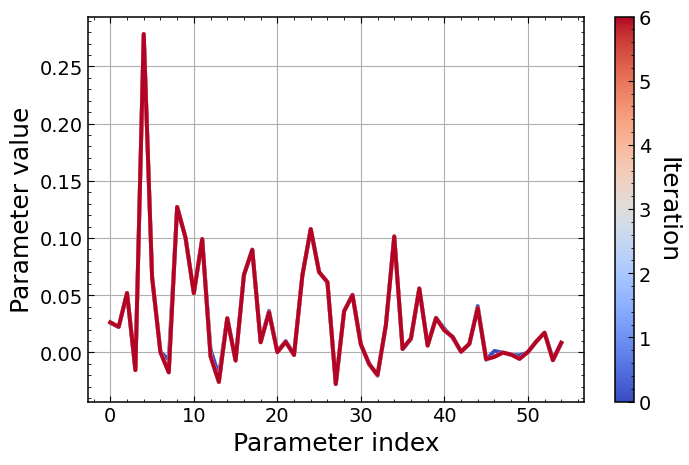

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

Theta0 = minim_dict['iter'][0]['Theta'].copy()

for iter in range(minim_dict['numiter']):
    Theta = minim_dict['iter'][iter]['Theta']
    ax.plot(Theta, color=colors[iter])

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=minim_dict['numiter']))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Iteration', rotation=270, labelpad=20)

ax.set_xlabel('Parameter index')
ax.set_ylabel('Parameter value')
ax.grid()

plt.show()

As we have seen in example `05-Inverse-Design`, very small changes in SNAP parameters lead to substantial changes in the equilibirum structures.